In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns

%matplotlib inline

# Hotel Reservation Cancellation Prediction 

This dataset represents observation of a hotel booking. Datasets comprehend bookings due to arrive between the **1st of July of 2015 and the 31st of August 2017**, including bookings that effectively arrived and bookings that were canceled. Since this is hotel real data, all data elements pertaining hotel or costumer identification were deleted.

### Load Dataset

In [13]:
df = pd.read_csv('Datasets/hotel_bookings.csv')

In [14]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [15]:
df.shape

(119390, 32)

***As per test requirement: The dataset was limited to 30,000 row***

In [18]:
df = df.iloc[0:3001]

In [19]:
df.shape

(3001, 32)

### Feature Description

- hotel : (Categorical) indicating type of Hotel : Resort Hotel
- is_canceled: ***1 for cancelled booking, 0 for not-cancelled booking*** . This is target value
- lead_time: Num of days that elapsed between the entered date of the booking into the System and Arrival Date
- arrival_date_year: Year of arrival date
- arrival_date_month: Month of arrival date
- arrival_date_week_number: Week number of **year** of arrival date (1-52)
- arrival_date_day_of_month: Day of Arrival Date
- stays_in_weekend_nights: Number of **weekend nights (Sat/Sun)*** the guest stayed or booked to stay at the hotel
- stays_in_week_nights: Number of **week nights (Sat/Sun)*** the guest stayed or booked to stay at the hotel
- adults: Number of adults
- children: Number of children
- babies: Number of babies (will not be charged or counted as pax)
- meal:
    - BB (Bed and Breakfast)
    - Undefined / SC (no meal package)
    - HB (Halfboard - breakfast + 1 other meal)
    - FB (Fullboard - breakfast + Lunch + Dinner)
- country: (Categorical) Country of Origin in ISO format
- market_segment:
    - TA (Travel Agents)
    - TO (Tour Operators)
- distribution_channel:
    - TA (Travel Agents)
    - TO (Tour Operators)
- is_repeated_guest: Booking name from repeated guest. If the guest was registered in the system prior booking. Then it's considered as repeated guest
- previous_cancellations: Number of previous bookings that were **cancelled** by a customer prior the current booking
- previous_bookings_not_canceled: Number of previous bookings that were **not cancelled** by a customer prior the current booking
- reserved_room_type: Type of rooms booked (encoded for anonymity)
- assigned_room_type: Type of rooms assigned (encoded for anonymity)
- booking_changes: How many booking changes made by guest (persons name, arrival date, type of rooms, etc.) before check in
- deposit_type:
    - No Deposit
    - Non Refund (a deposit was made in the value of total stay cost)
    - Refundable (a deposit was made with a value under the total cost of stay)
- agent: ID of travel agent that made the booking
- company: ID of the company that made the booking and responsible for payment (encoded for anonymity) - indicates travel business
- days_in_waiting_list: Number of days the booking was in the waiting list before it was confirmed to customer:
- customer_type:
    - Contract
    - Group: Associated to group
    - Transient: not associated to group or contract
    - Transient-Party: when the booking is transient but is associated to at least other transient booking
- adr: Average Daily Rate (*** SUM OF ALL LODGING TRANSACTION/TOTAL NUMBER OF STAYING NIGHTS)
- required_car_parking_spaces: Number of parking spaces required by customer
- total_of_special_requests: Number of special requests made by the customers
- reservation_status:
    - Canceled : booking was cancelled
    - Check-out: Customer has checked in but already departed
    - No-Show: Customer did not check in and **did inform the hotel of reason why**
- reservation_status_date: Date of last reservation_status update

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

In [7]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

## Data Preprocessing

#### 1. Fixing Data Types
Some column data type need to be converted

In [24]:
# arrival_date_month supposed to be integer
df['arrival_date_month'].value_counts()

July         842
October      748
August       643
September    602
November     166
Name: arrival_date_month, dtype: int64

That was actually ok. But we will encode this feature before going to Model

In [25]:
# children
df['children'].value_counts()

0.0     2733
2.0      140
1.0      127
10.0       1
Name: children, dtype: int64

In [26]:
# since there is no half children, we will convert this to int
df['children'] = df['children'].astype(int)

#### Handling missing data

In [28]:
df.isna().sum()

hotel                                0
is_canceled                          0
lead_time                            0
arrival_date_year                    0
arrival_date_month                   0
arrival_date_week_number             0
arrival_date_day_of_month            0
stays_in_weekend_nights              0
stays_in_week_nights                 0
adults                               0
children                             0
babies                               0
meal                                 0
country                              1
market_segment                       0
distribution_channel                 0
is_repeated_guest                    0
previous_cancellations               0
previous_bookings_not_canceled       0
reserved_room_type                   0
assigned_room_type                   0
booking_changes                      0
deposit_type                         0
agent                              465
company                           2878
days_in_waiting_list     

In [33]:
#company

df['company'].value_counts()

281.0    43
110.0    18
307.0     8
268.0     7
94.0      5
223.0     4
317.0     4
154.0     4
113.0     3
174.0     3
270.0     3
195.0     3
59.0      2
178.0     2
274.0     2
312.0     2
240.0     2
204.0     1
286.0     1
53.0      1
318.0     1
47.0      1
118.0     1
12.0      1
144.0     1
Name: company, dtype: int64

In [32]:
# company
df[df['company'].isna()]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,Resort Hotel,1,39,2015,November,46,10,0,5,1,...,No Deposit,281.0,NaN,0,Transient-Party,40.0,0,0,Canceled,2015-10-10
2997,Resort Hotel,0,36,2015,November,46,10,0,5,2,...,No Deposit,250.0,NaN,0,Transient,73.2,1,0,Check-Out,2015-11-15
2998,Resort Hotel,0,0,2015,November,46,11,0,1,2,...,No Deposit,NaN,NaN,0,Transient,79.0,1,0,Check-Out,2015-11-12
2999,Resort Hotel,0,6,2015,November,46,11,0,1,1,...,No Deposit,96.0,NaN,0,Transient,37.0,1,0,Check-Out,2015-11-12


***company*** columns contains id of company that is responsible for payment. NaN values company means that the booking/trip is not related to business purpose. I will put 0 that means it is private/leisure booking

The reason was i want to examine cancelled trip based on trip purpose later in the EDA

In [34]:
df['company'].fillna(0, inplace=True)

In [36]:
# agent
df['agent'].value_counts()

240.0    1242
250.0     246
241.0     151
242.0      68
40.0       56
         ... 
303.0       1
273.0       1
244.0       1
167.0       1
304.0       1
Name: agent, Length: 66, dtype: int64

In [40]:
df[df['agent'].isna()]['distribution_channel'].value_counts()

Direct       381
Corporate     76
TA/TO          8
Name: distribution_channel, dtype: int64

NaN agent distribution channel mostly comes from direct and corporate. It's normal. I will just leave it

In [31]:
df['country'].value_counts()

PRT    1776
ESP     343
GBR     316
IRL     143
FRA      79
DEU      38
NLD      35
CN       28
USA      27
BEL      22
CHE      22
POL      19
RUS      18
ITA      15
BRA      13
ROU      12
AUT      10
FIN       8
SWE       7
LVA       6
DNK       5
NOR       4
ARG       4
LUX       4
CHN       3
IND       3
AUS       3
OMN       2
TUR       2
MAR       2
EST       2
SVN       2
DZA       2
MOZ       2
LTU       2
MEX       2
CHL       2
CZE       2
ZMB       1
BWA       1
ZAF       1
UKR       1
SRB       1
CPV       1
ALB       1
CYM       1
ZWE       1
GRC       1
SMR       1
AGO       1
PRI       1
ISR       1
BLR       1
Name: country, dtype: int64

In [29]:
df[df['country'].isna()]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
30,Resort Hotel,0,118,2015,July,27,1,4,10,1,...,No Deposit,NaN,NaN,0,Transient,62.0,0,2,Check-Out,2015-07-15


It is also common for hotels not to know the correct nationality of the customer until the moment of check-in. [[1](https://www.sciencedirect.com/science/article/pii/S2352340918315191)]

In [44]:
df.isna().sum()

hotel                               0
is_canceled                         0
lead_time                           0
arrival_date_year                   0
arrival_date_month                  0
arrival_date_week_number            0
arrival_date_day_of_month           0
stays_in_weekend_nights             0
stays_in_week_nights                0
adults                              0
children                            0
babies                              0
meal                                0
country                             1
market_segment                      0
distribution_channel                0
is_repeated_guest                   0
previous_cancellations              0
previous_bookings_not_canceled      0
reserved_room_type                  0
assigned_room_type                  0
booking_changes                     0
deposit_type                        0
agent                             465
company                             0
days_in_waiting_list                0
customer_typ

## Exploratory Data Analysis

### 1. Booking trends over time

In [45]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,0.0,0,Transient,98.0,0,1,Check-Out,2015-07-03


We don't have information where is the hotels in this dataset. So I couldn't really tell which season for each month of guest occupancy.

However we can check booking trends over months. Please note that the datasets was taken not in full years. which means there are some months might be repeated

In [47]:
df['arrival_months_year'] = df['arrival_date_month'].astype(str) + ' ' + df['arrival_date_year'].astype(str)

In [48]:
df['arrival_months_year'].value_counts()

July 2015         842
October 2015      748
August 2015       643
September 2015    602
November 2015     166
Name: arrival_months_year, dtype: int64

There are no repeated months, so we will proceed visualize it

In [52]:
df.groupby('arrival_date_month').agg('count')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_months_year
arrival_date_month,,,,,,,,,,,,,,,,,,,,,
August,643,643,643,643,643,643,643,643,643,643,...,555,643,643,643,643,643,643,643,643,643
July,842,842,842,842,842,842,842,842,842,842,...,763,842,842,842,842,842,842,842,842,842
November,166,166,166,166,166,166,166,166,166,166,...,146,166,166,166,166,166,166,166,166,166
October,748,748,748,748,748,748,748,748,748,748,...,530,748,748,748,748,748,748,748,748,748
September,602,602,602,602,602,602,602,602,602,602,...,542,602,602,602,602,602,602,602,602,602


In [ ]:
plt.figure(12,8)


**city vs resort hotel**

count based on average pax count

#### 1.2 Cancellation trends over time

#### 1.3 ratio booking / cancelled

In [61]:
## type of trip

## Preprocessing part 2.

### 1. Check for target feature ( balance or imbalance )?

In [55]:
df['is_canceled'].value_counts()

0    1937
1    1064
Name: is_canceled, dtype: int64

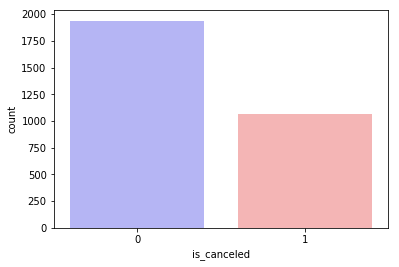

In [60]:
sns.countplot(x="is_canceled", data=df, palette="bwr")
plt.show()

It's quite balanced. we will proceed to next step

### 2. Encode categorical data

In [142]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_months_year
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,NaN,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01,July 2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,NaN,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01,July 2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,NaN,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,July 2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,304.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,July 2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,240.0,0.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,July 2015


In [146]:
## reduce number of column because i keep getting error
df_process = df.drop(['arrival_date_year', 'assigned_room_type', 'booking_changes','reservation_status_date', 'arrival_months_year', 'reservation_status'], axis=1)


In [147]:
# Making the numerical features and categorical features for one-hot encoding and simple imputing
numerical_features = list(df_process.select_dtypes(exclude = [object]))
categorical_features = list(df_process.select_dtypes(include = [object]))
numerical_features.remove('is_canceled')

In [154]:
# Changing the dataset into dependent and independent variables
X = df_process.drop(['is_canceled'], axis = 1)[numerical_features + categorical_features]
y = df_process['is_canceled'].values

In [160]:
# Pre-processing features

numeric_transformer = SimpleImputer(strategy = 'constant')
categoric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'Unknown')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])
preprocessor = ColumnTransformer(transformers = [('numeric', numeric_transformer, numerical_features),
                                               ('categorical', categoric_transformer, categorical_features)])
X = preprocessor.fit_transform(X)

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

## Splitting Dataset

In [158]:
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2)

## Train Model

We will use classifier ML and compare the performance

Decision Tree Classifier

In [159]:
model_dct = DecisionTreeClassifier()
model_dct.fit(X_train, y_train)

ValueError: Unknown label type: 'continuous-multioutput'

## Random Forest Classifier

In [137]:
model_rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'bootstrap': [True],
    'max_depth': [4,5,6,7,8],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000],
    'criterion' : ['gini', 'entropy']
}
gs_rf = RandomizedSearchCV(estimator = model_rf, param_distributions = param_grid_rf, cv = 5, n_jobs = -1, verbose = 2)
gs_rf = gs_rf.fit(X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [2700, 301]

In [127]:
model_rfc = RandomForestClassifier(n_estimators = 2000, min_samples_split= 2, min_samples_leaf = 1, max_depth = 25)
model_rfc.fit(X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [2700, 301]

## Evaluation Matrix